# Proyecto Modulo 5 - Modelos de agrupamiento, Evaluación de modelos y selección de modelos

**IMPORTANTE: EJECUTAR ESTE PRIMER BLOQUE DE CODIGO INDIVIDUALMENTE ANTES DE EJECUTAR EL RESTO DEL CODIGO**

In [15]:
import pandas as pd
import cufflinks as cf
# from IPython.display import display
cf.set_config_file(sharing='public', theme='pearl', offline=True)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import plotly.express as px
import os
import sys
%pip install -q ipywidgets
import ipywidgets as widgets

directorio = '../Data'
# directorio = '/content'

# Leer archivos xlsx dentro de la carpeta Data
files = os.listdir(directorio)
files = [f for f in files if f.endswith('.xlsx')]

# Seleccionar archivo a leer
dropdown = widgets.Dropdown(
  options=[('Seleccionar archivo', None)] + [(f, f) for f in files],
  description='Archivo:',
  disabled=False,
)
nombre_archivo = '';
def on_change(change):
  if change['type'] == 'change' and change['name'] == 'value':
    if change['new'] is not None:
      global nombre_archivo
      nombre_archivo = change['new']
      print('Archivo seleccionado:', nombre_archivo)

dropdown.observe(on_change)
display(dropdown)


Note: you may need to restart the kernel to use updated packages.


Dropdown(description='Archivo:', options=(('Seleccionar archivo', None), ('00_df_sin_participacion.xlsx', '00_…

Archivo seleccionado: 04_dataset_limpio_sin_outliers.xlsx


In [16]:
ruta = directorio + '/' + nombre_archivo
print('Ruta:', ruta)
# Leer archivo
dataset = pd.read_excel(ruta)
dataset.info()

Ruta: ../Data/04_dataset_limpio_sin_outliers.xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   carrera                                      1041 non-null   object 
 1   Comunidad                                    1041 non-null   object 
 2   Espacio_Académico                            1041 non-null   object 
 3   alumnos                                      1041 non-null   int64  
 4   1p_total_actividades_asignadas               1041 non-null   int64  
 5   1p_total_actividades_evaluativas             1041 non-null   int64  
 6   1p_porcentaje_evidencias_calificadas         1041 non-null   float64
 7   1p_total_actividades_calificadas             1041 non-null   int64  
 8   1p_total_actividades_entregadas              1041 non-null   float64
 9   1p_porcentaje_evidencias

In [17]:
datos_categoricos = dataset.select_dtypes(include=['object'])
datos_numericos = dataset.select_dtypes(exclude=['object'])
datos_categoricos.info()
datos_numericos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   carrera            1041 non-null   object
 1   Comunidad          1041 non-null   object
 2   Espacio_Académico  1041 non-null   object
dtypes: object(3)
memory usage: 24.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   alumnos                                      1041 non-null   int64  
 1   1p_total_actividades_asignadas               1041 non-null   int64  
 2   1p_total_actividades_evaluativas             1041 non-null   int64  
 3   1p_porcentaje_evidencias_calificadas         1041 non-null   float64
 4   1p_total_actividades_calificadas             1041 non-null   i

In [18]:
# dado que las comunidades/materias pueden tener nombres diferentes, no se consideran como variables categóricas para el análisis
# se eliminan las columnas de comunidades y materias
datos_categoricos = datos_categoricos.drop(columns=['Comunidad'])

In [19]:
# escalar los datos numéricos
scaler = StandardScaler()
datos_numericos_escalados = scaler.fit_transform(datos_numericos)
datos_numericos_escalados = pd.DataFrame(datos_numericos_escalados, columns=datos_numericos.columns)
datos_numericos_escalados.head()

,alumnos,1p_total_actividades_asignadas,1p_total_actividades_evaluativas,1p_porcentaje_evidencias_calificadas,1p_total_actividades_calificadas,1p_total_actividades_entregadas,1p_porcentaje_evidencias_calificadas_tiempo,1p_total_actividades_calificadas_tiempo,1p_porcentaje_aprobados,2p_total_actividades_asignadas,...,2p_porcentaje_evidencias_calificadas,2p_total_actividades_calificadas,2p_total_actividades_entregadas,2p_porcentaje_evidencias_calificadas_tiempo,2p_total_actividades_calificadas_tiempo,2p_porcentaje_aprobados,total_actividades_calificadas,trabajos_por_calificar,correos_enviados,correos_recibidos
0,0.249205,2.623283,3.009601,0.323726,3.033671,3.072770,0.969047,3.631524,-1.829183,3.214953,...,0.378051,3.635855,3.680632,1.023180,4.360825,-1.763419,3.472503,-0.22051,-0.552804,-0.933567
1,0.059707,2.879820,3.286661,0.323726,2.678263,2.709112,0.974303,3.259528,-1.829183,3.482427,...,0.378051,2.859660,2.888193,1.023180,3.507356,-1.763419,2.883314,-0.22051,2.491251,0.636584
2,1.954684,-0.711700,-0.592179,0.323726,0.002826,-0.028427,0.974303,0.379219,-1.829183,-1.867049,...,-2.718341,-1.236923,-1.294119,-1.624738,-0.997059,-1.763419,-0.668182,-0.22051,-0.409795,-0.906955
3,-0.603535,-0.455162,-0.315119,0.323726,-0.411817,-0.452695,0.974303,-0.067176,-1.829183,0.807689,...,0.378051,0.261564,0.235727,1.023180,0.650608,0.351645,-0.139004,-0.22051,0.693419,0.743035
4,-0.224539,-0.455162,-0.315119,0.323726,-0.283475,-0.321374,0.974303,0.070994,-1.829183,0.807689,...,0.378051,0.240003,0.213715,1.023180,0.626901,-0.457824,-0.078994,-0.22051,0.672990,0.237393


In [20]:
# codificar las variables categóricas

encoder = OneHotEncoder()
datos_categoricos_codificados = encoder.fit_transform(datos_categoricos).toarray()

# Crear nombres de características manualmente
feature_names = []
for i, column in enumerate(datos_categoricos.columns):
    feature_names.extend([f"{column}_{category}" for category in encoder.categories_[i]])

datos_categoricos_codificados = pd.DataFrame(datos_categoricos_codificados, columns=feature_names)
datos_categoricos_codificados.head()

,carrera_Ingeniería en Computación,carrera_Ingeniería en Computación (2019),carrera_Licenciado en Actuaría,carrera_Licenciado en Administración,carrera_Licenciado en Contaduría,carrera_Licenciado en Derecho 2023B,carrera_Licenciado en Derecho Internacional,carrera_Licenciado en Gastronomía,carrera_Licenciado en Gestión de la Información en Redes Sociales,carrera_Licenciado en Informática Administrativa,...,Espacio_Académico_Enfermería y Obstetricia,Espacio_Académico_Lenguas,Espacio_Académico_Medicina,Espacio_Académico_Temascaltepec,Espacio_Académico_Tenancingo,Espacio_Académico_Tlalnepantla,Espacio_Académico_Turismo y Gastronomía,Espacio_Académico_Valle de Chalco,Espacio_Académico_Valle de México,Espacio_Académico_Zumpango
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelado

Definir metodo KMEANS

In [21]:
def Kmeans(df):
  # Create a KMeans instance with 3 clusters: model
  inercia = []
  # Obtener gráfico de Elbow
  for k in range(1, 11):
    model = KMeans(n_clusters=k, n_init=10)
    # dont show output
    model.fit(df)
    inercia.append(model.inertia_)

  plt.plot(range(1, 11), inercia, marker='o')
  plt.xlabel('Numero de clusters')
  plt.ylabel('Inercia')
  plt.show()

  n_clusters = int(input("Ingrese el número de clusters: "))
  print(f"Se seleccionaron {n_clusters} clusters")
  model = KMeans(n_clusters=n_clusters, n_init=10)
  model.fit(df)

  labels = model.predict(df)
  df_labels = df.copy()
  df_labels['cluster'] = labels
  return df_labels


In [22]:
def hierarchical_clustering(df):
  Z = linkage(df, method='ward')
  plt.figure(figsize=(25, 10))
  plt.title('Dendrograma jerárquico para el Clustering')
  plt.xlabel('Índices de la Muestra')
  plt.ylabel('Distancias')
  dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
  plt.show()

  threshold = int(input("Ingrese threshold para el número de clusters: "))
  print(f"Distance threshold: {threshold} ")
  # plot dendrogram
  plt.figure(figsize=(25, 10))
  plt.title('Dendrograma jerárquico para el Clustering After Cutting, threshold = {}'.format(threshold))
  plt.xlabel('Índices de la Muestra')
  plt.ylabel('Distancias')
  dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
  plt.axhline(y=threshold, c='k')
  plt.show()

  labels = fcluster(Z, t=threshold, criterion='distance')

  print(f"Se seleccionaron {len(np.unique(labels))} clusters")
  df_labeled = df.copy()
  df_labeled['cluster'] = labels
  return df_labeled

In [23]:
def PCA_clustering(df):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  finalDf = pd.concat([principalDf, df[['cluster']]], axis = 1)

  fig = px.scatter(finalDf, x='principal component 1', y='principal component 2', color='cluster')
  # increase the graph size
  fig.update_layout(
    title='Clusters',
    scene=dict(
        xaxis=dict(title='PCA 1'),
        yaxis=dict(title='PCA 2'),
        # zaxis=dict(title='PCA 3')
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    height=800,
    width=800
  )
  fig.show()
  

  return finalDf

In [24]:
def input_categoricos(categoricos, numericos):
  respuesta = input("Desea usar las variables categóricas? (s/n): ")
  if respuesta == 's':
    print("Se usarán las variables categóricas, con codificación one-hot")
    return pd.concat([categoricos, numericos], axis=1)
  else:
    print("No se usarán las variables categóricas solo las numéricas")
    return numericos

In [25]:
def main(metodo = None): # 1: Kmeans, 2: Clustering jerárquico
  df_modelo = input_categoricos(datos_categoricos_codificados, datos_numericos_escalados)

  print("Seleccione el método de clustering a utilizar: ")
  print("1. Kmeans")
  print("2. Clustering jerárquico")
  if metodo is not None:
    print(f"Se seleccionó el método {metodo}")
  else: 
    metodo = int(input("Ingrese el número del método: "))
  
  if metodo == 1:
    df = Kmeans(df_modelo)
  elif metodo == 2:
    df = hierarchical_clustering(df_modelo)
  else:
    print("Opción no válida")
    return
  display(df)
  PCA_clustering(df)
  return df


Se usarán las variables categóricas, con codificación one-hot
Seleccione el método de clustering a utilizar: 
1. Kmeans
2. Clustering jerárquico
Se seleccionó el método 1


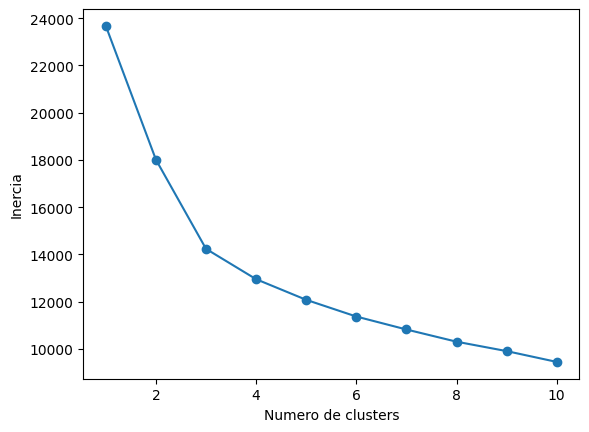

Se seleccionaron 3 clusters


,carrera_Ingeniería en Computación,carrera_Ingeniería en Computación (2019),carrera_Licenciado en Actuaría,carrera_Licenciado en Administración,carrera_Licenciado en Contaduría,carrera_Licenciado en Derecho 2023B,carrera_Licenciado en Derecho Internacional,carrera_Licenciado en Gastronomía,carrera_Licenciado en Gestión de la Información en Redes Sociales,carrera_Licenciado en Informática Administrativa,...,2p_total_actividades_calificadas,2p_total_actividades_entregadas,2p_porcentaje_evidencias_calificadas_tiempo,2p_total_actividades_calificadas_tiempo,2p_porcentaje_aprobados,total_actividades_calificadas,trabajos_por_calificar,correos_enviados,correos_recibidos,cluster
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.635855,3.680632,1.023180,4.360825,-1.763419,3.472503,-0.220510,-0.552804,-0.933567,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.859660,2.888193,1.023180,3.507356,-1.763419,2.883314,-0.220510,2.491251,0.636584,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.236923,-1.294119,-1.624738,-0.997059,-1.763419,-0.668182,-0.220510,-0.409795,-0.906955,2
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.261564,0.235727,1.023180,0.650608,0.351645,-0.139004,-0.220510,0.693419,0.743035,1
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.240003,0.213715,1.023180,0.626901,-0.457824,-0.078994,-0.220510,0.672990,0.237393,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.962295,0.951122,0.723965,1.148465,0.429981,1.317601,-0.125043,-0.777533,-0.640827,0
1037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.059320,1.050177,-0.878025,-0.285836,-1.763419,1.323056,-0.220510,-0.940972,-0.002122,0
1038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.452586,3.493528,0.755740,3.637747,0.847772,3.434315,-0.220510,0.284821,-0.960180,0
1039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.393514,1.391366,0.784867,1.634468,0.221086,1.650383,-0.125043,0.489120,-1.066631,0


In [26]:
df_kmeans = main(1)

Se usarán las variables categóricas, con codificación one-hot
Seleccione el método de clustering a utilizar: 
1. Kmeans
2. Clustering jerárquico
Se seleccionó el método 2


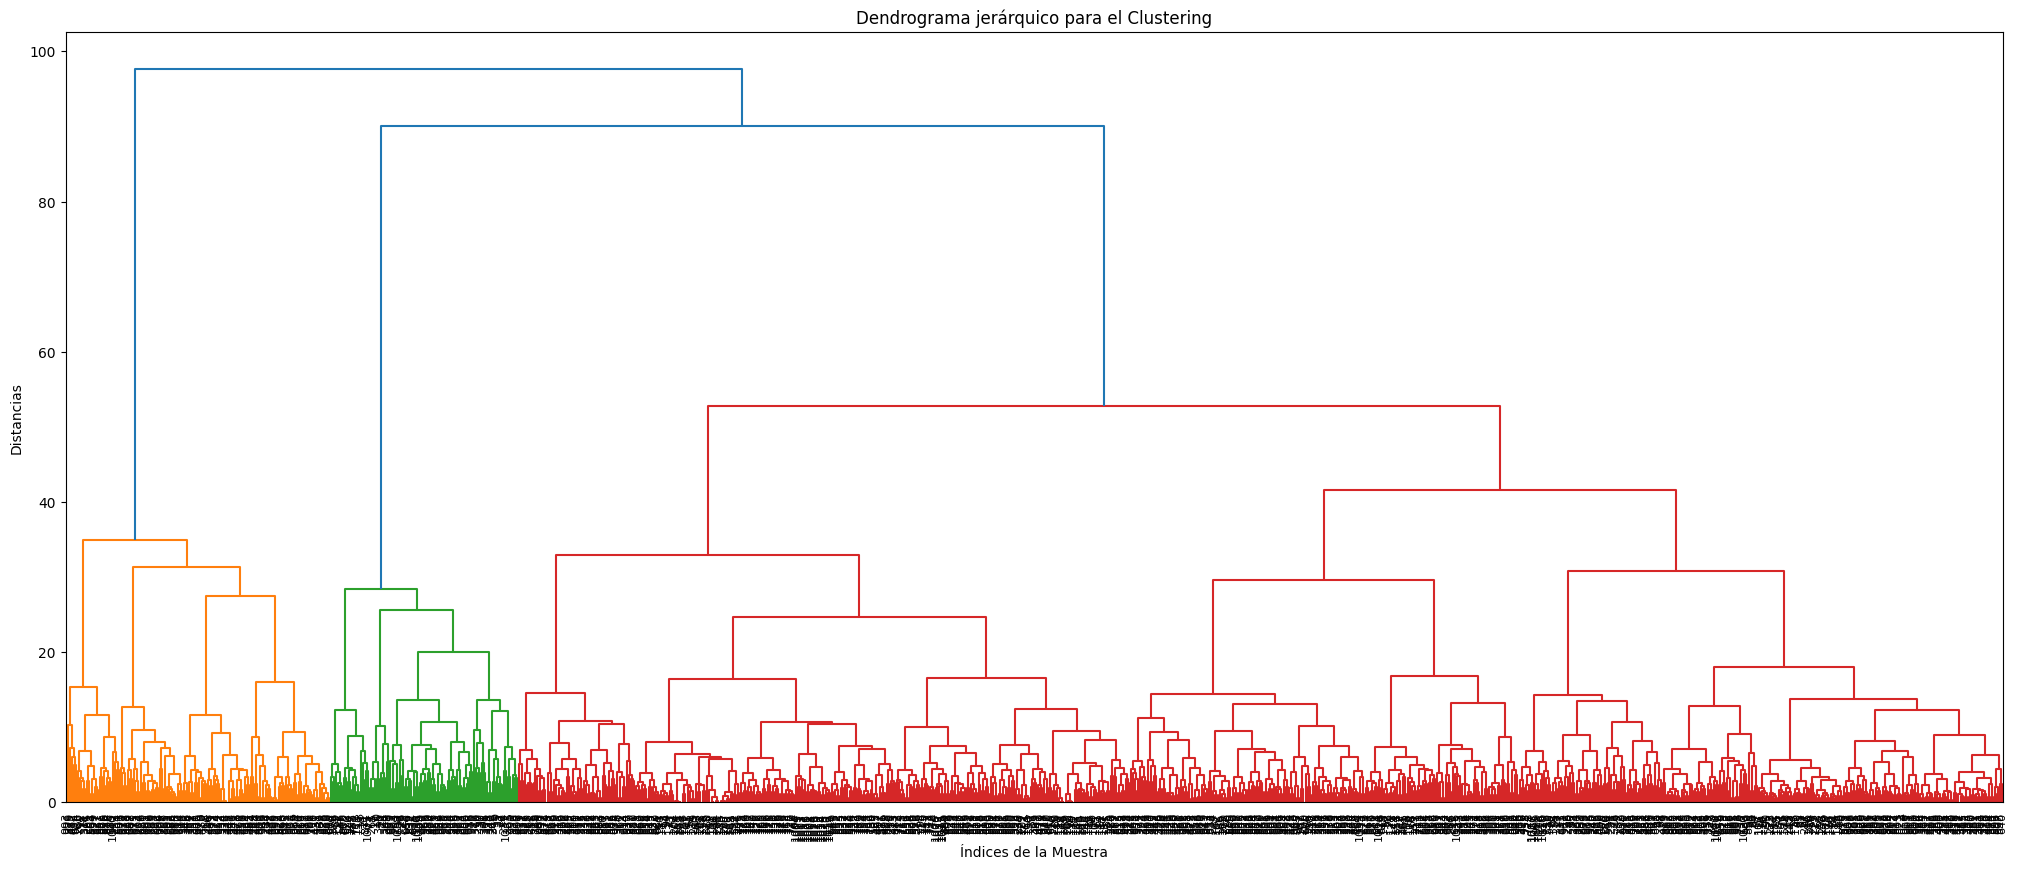

Distance threshold: 60 


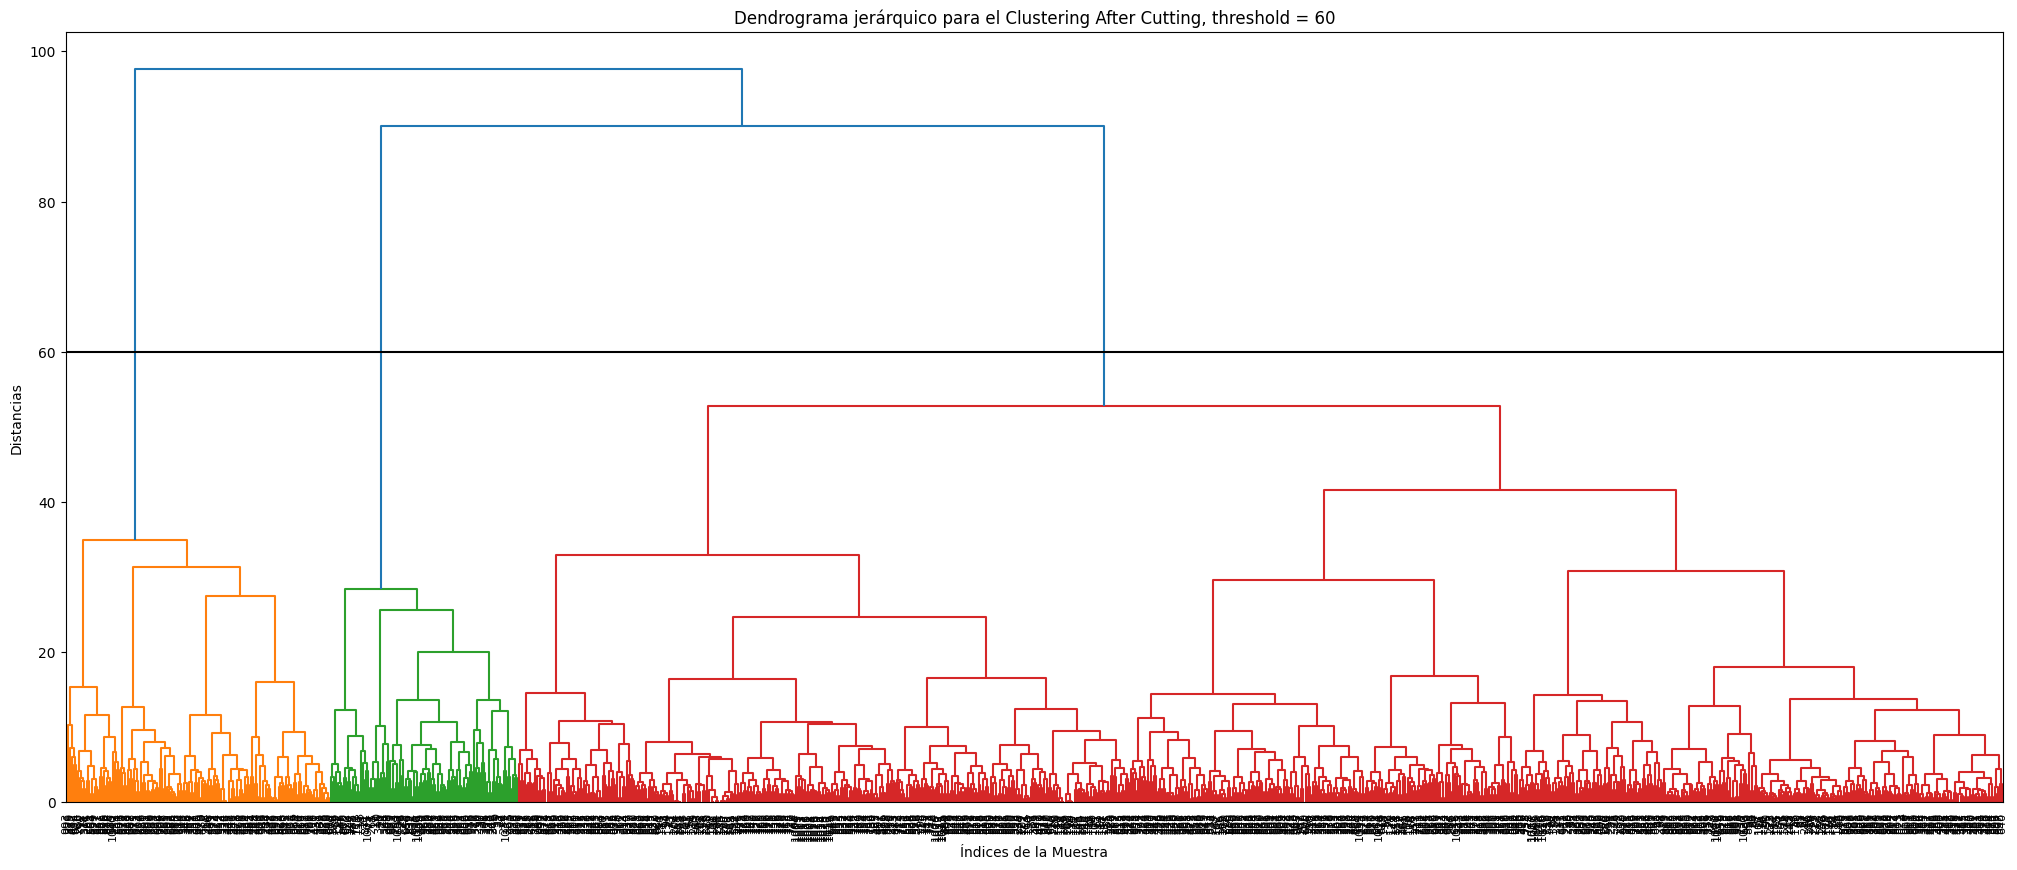

Se seleccionaron 3 clusters


,carrera_Ingeniería en Computación,carrera_Ingeniería en Computación (2019),carrera_Licenciado en Actuaría,carrera_Licenciado en Administración,carrera_Licenciado en Contaduría,carrera_Licenciado en Derecho 2023B,carrera_Licenciado en Derecho Internacional,carrera_Licenciado en Gastronomía,carrera_Licenciado en Gestión de la Información en Redes Sociales,carrera_Licenciado en Informática Administrativa,...,2p_total_actividades_calificadas,2p_total_actividades_entregadas,2p_porcentaje_evidencias_calificadas_tiempo,2p_total_actividades_calificadas_tiempo,2p_porcentaje_aprobados,total_actividades_calificadas,trabajos_por_calificar,correos_enviados,correos_recibidos,cluster
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.635855,3.680632,1.023180,4.360825,-1.763419,3.472503,-0.220510,-0.552804,-0.933567,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.859660,2.888193,1.023180,3.507356,-1.763419,2.883314,-0.220510,2.491251,0.636584,2
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.236923,-1.294119,-1.624738,-0.997059,-1.763419,-0.668182,-0.220510,-0.409795,-0.906955,1
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.261564,0.235727,1.023180,0.650608,0.351645,-0.139004,-0.220510,0.693419,0.743035,3
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.240003,0.213715,1.023180,0.626901,-0.457824,-0.078994,-0.220510,0.672990,0.237393,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.962295,0.951122,0.723965,1.148465,0.429981,1.317601,-0.125043,-0.777533,-0.640827,2
1037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.059320,1.050177,-0.878025,-0.285836,-1.763419,1.323056,-0.220510,-0.940972,-0.002122,2
1038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.452586,3.493528,0.755740,3.637747,0.847772,3.434315,-0.220510,0.284821,-0.960180,2
1039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.393514,1.391366,0.784867,1.634468,0.221086,1.650383,-0.125043,0.489120,-1.066631,2


In [27]:
df_hc = main(2)

In [28]:
# insertar los clusters en el dataset original
dataset['cluster_kmeans'] = df_kmeans['cluster']
dataset['cluster_hc'] = df_hc['cluster']

# el cluster de kmeans dio clusters del 0 al 2, mientras que el de clustering jerárquico dio clusters del 1 al 3
# convertir los clusters de clustering kmeans a 1, 2 y 3
dataset['cluster_kmeans'] = dataset['cluster_kmeans'].apply(lambda x: x+1)

In [32]:
# input del el nombre del archivo sin extensión y sin espacios, pero si puede tener guiones si no cumple con un formato válido continuará pidiendo el nombre

nombre_archivo = '  '

def nombre_valido(nombre):
  # si contiene espacios retorna False
  if ' ' in nombre:
    return False
  nombre_normalizado = nombre.replace('-', '').replace('_', '')
  sigue_alfanumerico = nombre_normalizado.isalnum()
  print(f"nombre: {nombre}, nombre_normalizado: {nombre_normalizado}, sigue_alfanumerico: {sigue_alfanumerico}")
  return sigue_alfanumerico

while not nombre_valido(nombre_archivo):
  nombre_archivo = input("Ingrese el nombre del archivo de salida sin extensión y sin espacios: ")

directorio_salida = '../Results'
# directorio_salida = '/content'

if not os.path.exists(directorio_salida):
  os.makedirs(directorio_salida)

dataset.to_excel(f'{directorio_salida}/{nombre_archivo}.xlsx', index=False)

nombre: 04_clusters_sin_outliers, nombre_normalizado: 04clusterssinoutliers, sigue_alfanumerico: True
